<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Code/TrendRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of trend removal

Modified from Will Kleiber's demo 2018 by Stephen Becker 2022

Our data set will be Global historical climatology network temperature data for CO (1852-2011; units Celsius)

Some terminology
- Tx = Maximum temperature
- Tn = Minimum temperature
- Tm = Mean temperature (not available in this dataset)

In [1]:
load(url("https://github.com/stephenbeckr/time-series-class/raw/main/Data/CO-GHCND-TN-TX.RData"))
ls()

[1] "da"      "elev"    "lon.lat" "mo"      "sf"      "TN"      "TX"     
[8] "yr"

We have this data for different cities. Here are a few of them:

In [10]:
sf[120:130,6:7]

V6,V7
FLAGLER,16NNW
FLEMING,3SW
FLORENCE,
FLORISSANT,FOSSIL
FORDER,8
FT,COLLINS
FT,COLLINS
FORT,GARLAND
FT,LEWIS
FT,LUPTON


### Exploratory plots

V6        V7 
     "FT" "COLLINS"

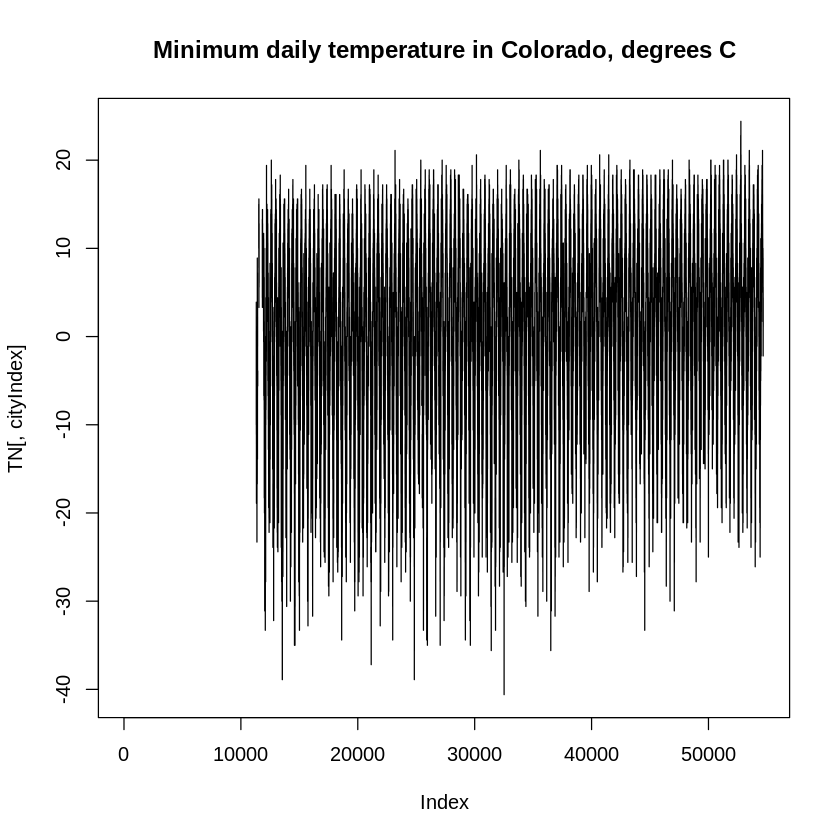

In [12]:
cityIndex = 125
sf[cityIndex,6:7]
plot(TN[,cityIndex],type="l",main="Minimum daily temperature in Ft Collins, degrees C")

In [13]:
# note number of days per year
table(yr)

yr
1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1866 1867 1868 
 365  365  365  365  365  365  365  365  365  365  365  365  365  365  365  365 
1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1893 
 365  365  365  365  365  365  365  365  365  365  365  365  365  365  365  365 
1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 
 365  365  365  365  365  365  365  365  365  365  365  365  365  365  365  365 
1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 
 365  365  365  365  365  365  365  365  365  365  365  365  365  365  365  365 
1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 
 365  365  365  365  365  365  365  365  365  365  365  365  365  365  365  365 
1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 
 365  365  365  365  365  365  365  365  365  365  365  365  365  365  365  365 
1958 1959 1960 1961 1962 

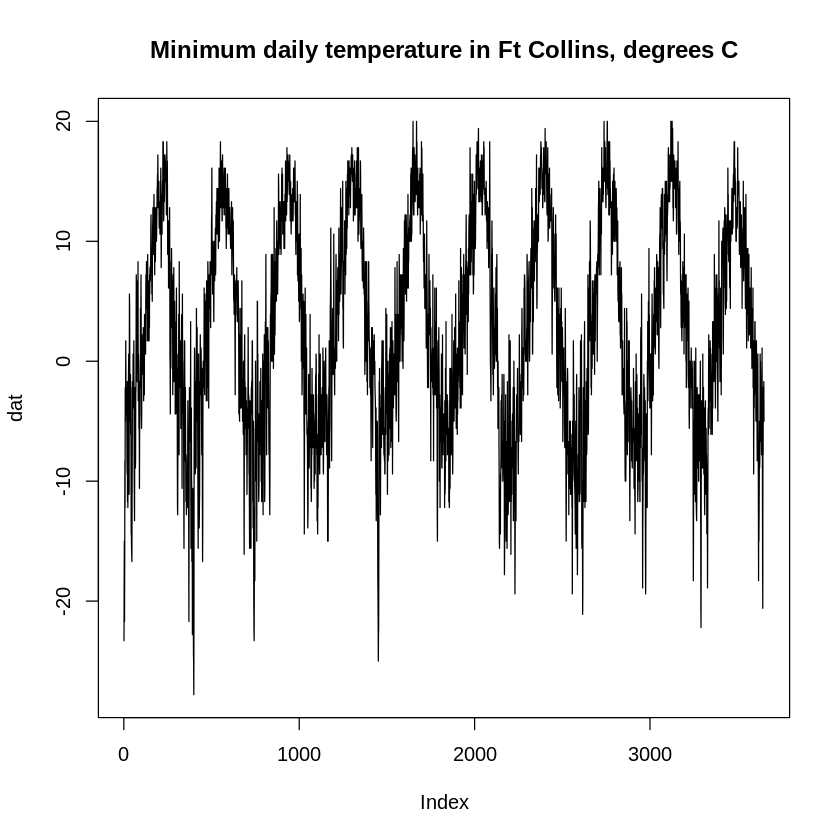

In [15]:
dat <- TN[yr %in% c(1995:2004),cityIndex]
plot(dat,type="l",main="Minimum daily temperature in Ft Collins, degrees C")

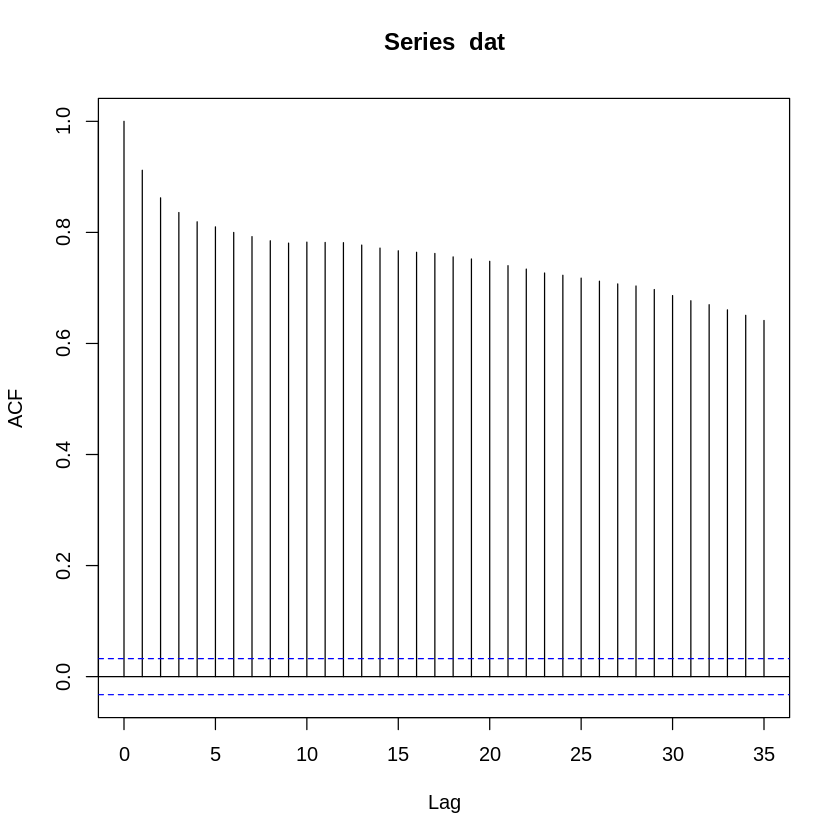

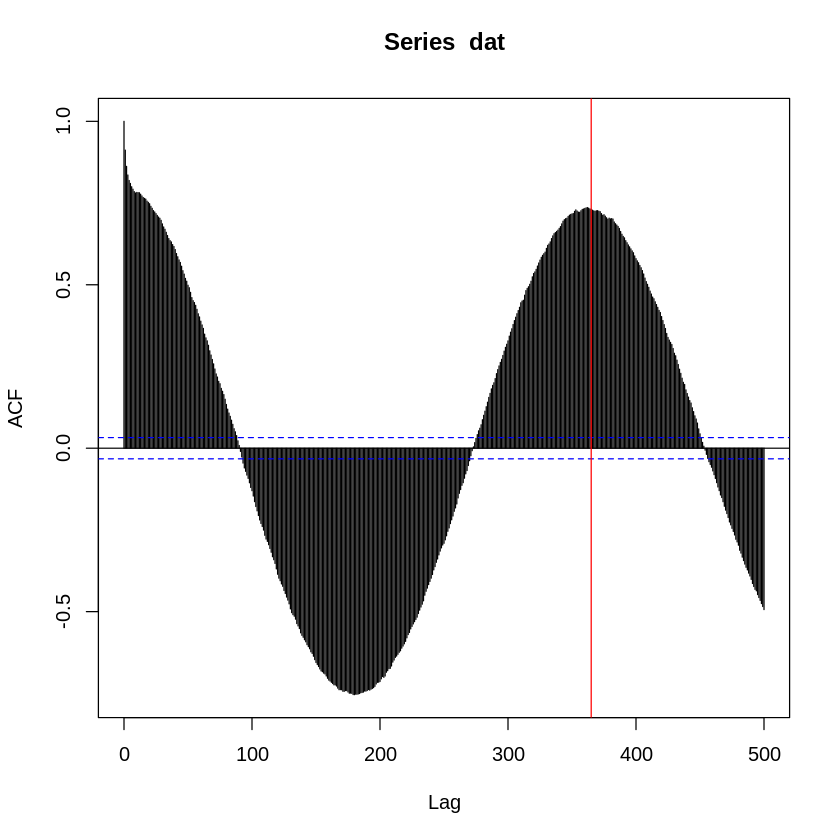

In [17]:
# what would you expect the acf to look like?
acf(dat)
acf(dat,lag.max=500)
abline(v=365,col="red")

Let's grab an even smaller subset for exposition

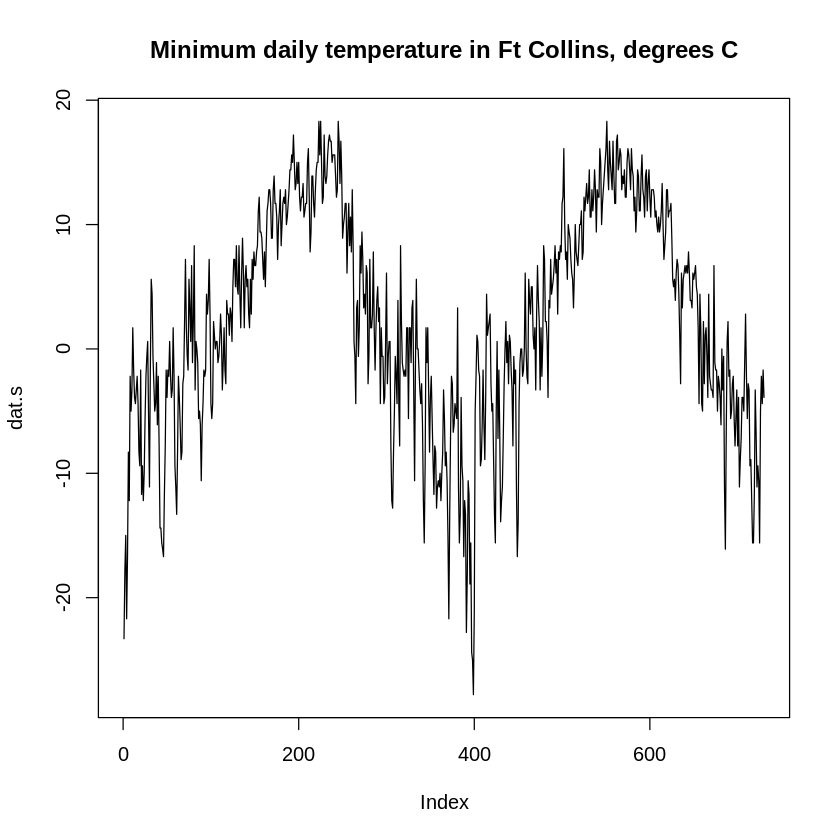

In [18]:
dat.s <- TN[yr %in% c(1995:1996),125]
plot(dat.s,type="l",main="Minimum daily temperature in Ft Collins, degrees C")

## Trend removal: smoothing filter (moving avg filter)

#### Past-value smoothing

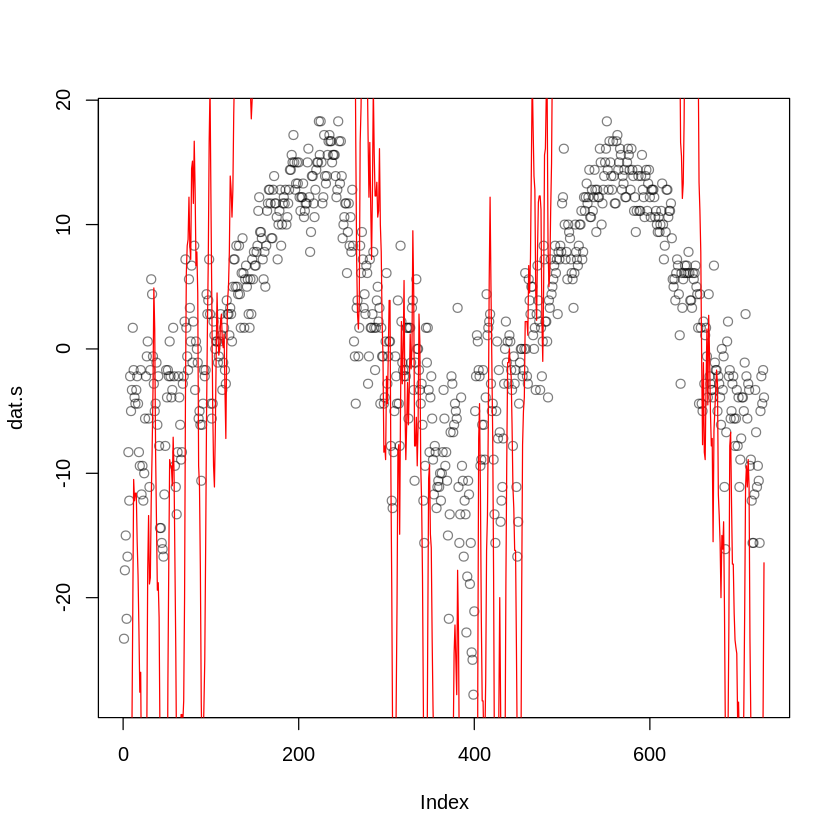

In [31]:
plot(dat.s,type="p",col=gray(0, .5) )

# the wrong way
tr.1 <- filter(x=dat.s,filter=rep(1,5),method="convolution",sides=1)
lines(tr.1,col="red")

What went wrong? Our filter wasn't scaled, so the output `tr.1` had the wrong amplitude. You could correct that later, but simpler to just scale the filter.

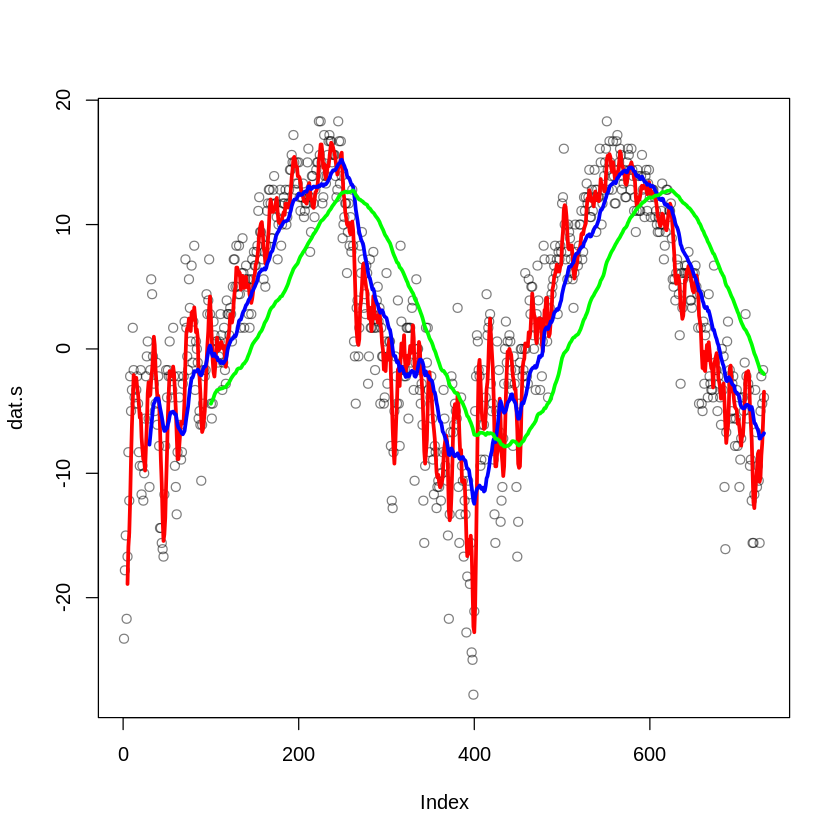

In [30]:
plot(dat.s,type="p",col=gray(0, .5) )
# The right way, trying various lengths of filters
tr.1 <- filter(x=dat.s,filter=rep(1,5)/5,method="convolution",sides=1)
lines(tr.1,col="red",lwd=3)

tr.2 <- filter(x=dat.s,filter=rep(1,30)/30,method="convolution",sides=1)
lines(tr.2,col="blue",lwd=3)

tr.3 <- filter(x=dat.s,filter=rep(1,100)/100,method="convolution",sides=1)
lines(tr.3,col="green",lwd=3)

#### Centered smoothing
Still use `filter` but now uses `sides=2`

Also, it's nicer to use odd-length filters to simplify things

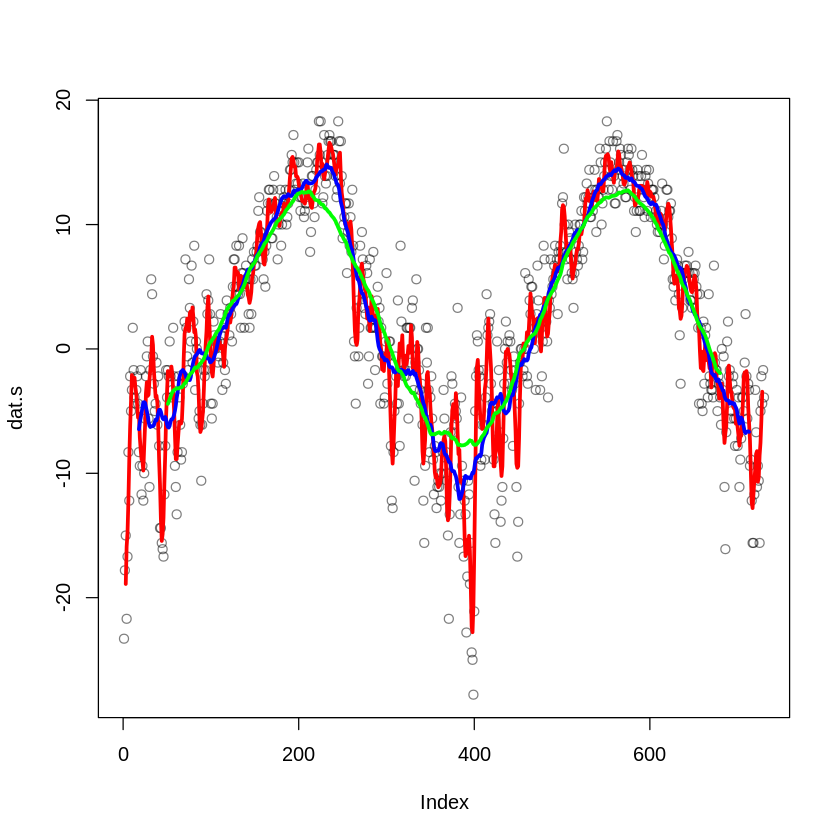

In [33]:
plot(dat.s,type="p",col=gray(0, .5) )

tr.1 <- filter(x=dat.s,filter=rep(1,5)/5,method="convolution",sides=2)
lines(tr.1,col="red",lwd=3)
tr.2 <- filter(x=dat.s,filter=rep(1,35)/35,method="convolution",sides=2)
lines(tr.2,col="blue",lwd=3)
tr.3 <- filter(x=dat.s,filter=rep(1,101)/101,method="convolution",sides=2)
lines(tr.3,col="green",lwd=3)

#### Look at residuals
(Applied to the medium sized data)

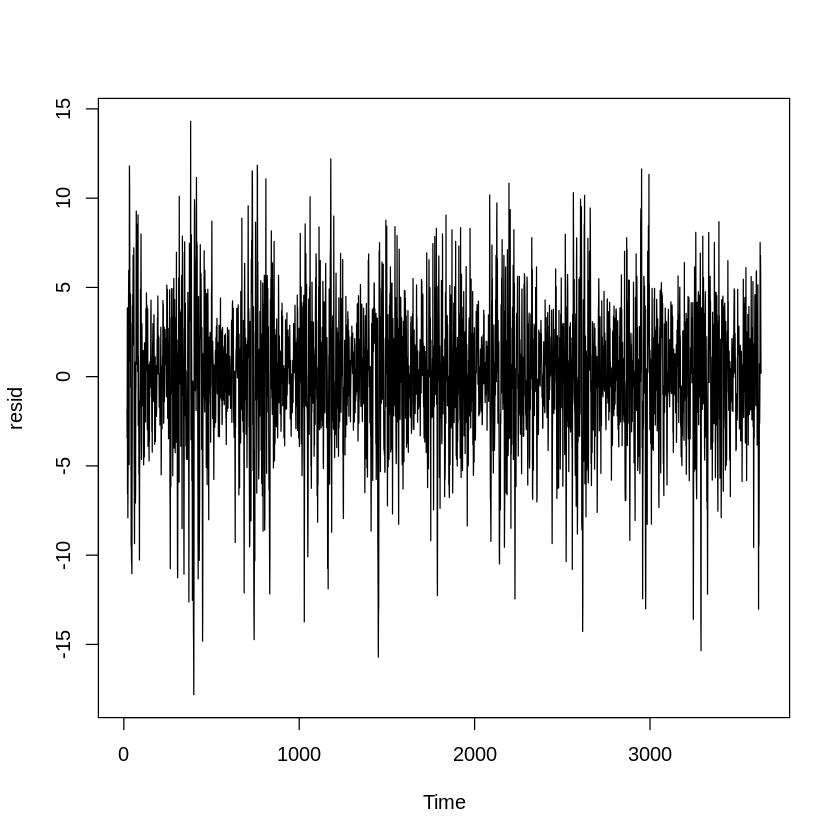

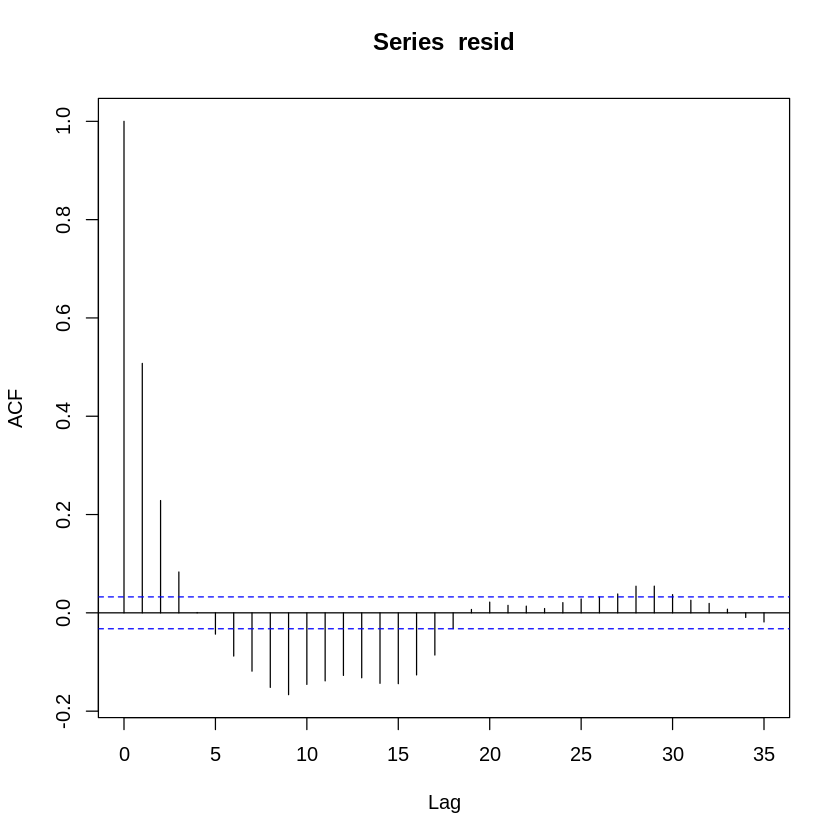

In [35]:
resid <- dat - filter(x=dat,filter=rep(1,35)/35,method="convolution",sides=2)
plot(resid,type="l")
# acf(resid)  # Trying this and there's a problem!
acf(resid,na.action=na.pass) # Ignore N/A values

## Trend/season removal, method 1
We'll use builtin [`decompose`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/decompose.html)

In [37]:
decompose(dat)

ERROR: ignored

What happened? `decompose` expects a `ts` object (which stands for "time series")

[1] "ts"

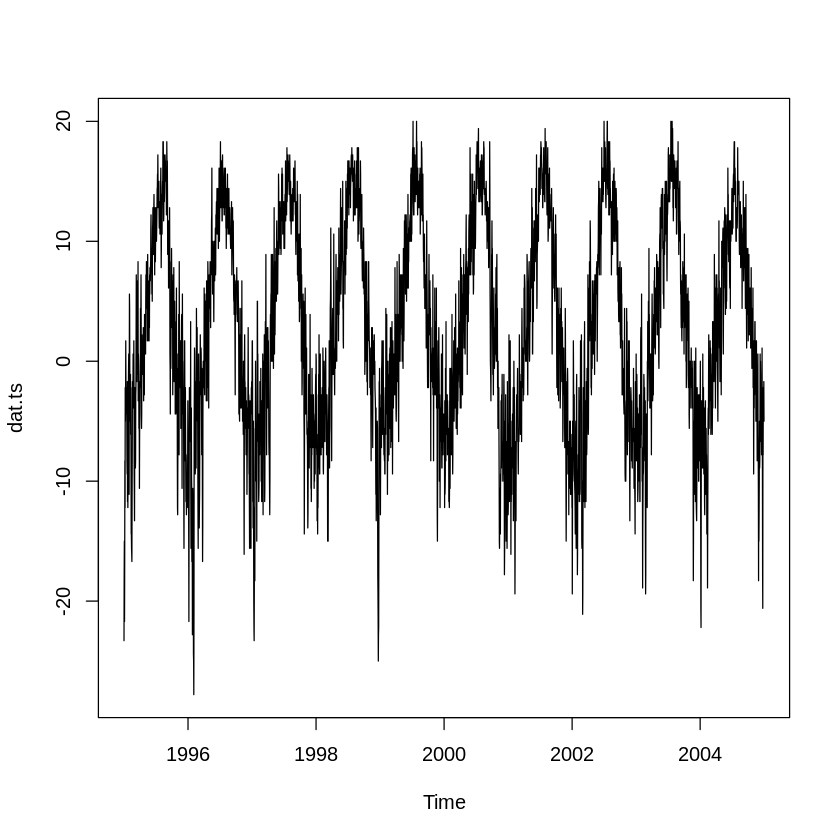

In [38]:
# convert to a time series object
dat.ts <- ts(data=dat,start=c(1995,1),end=c(2004,365),frequency=365)

class(dat.ts)

plot(dat.ts)

[1] "x"        "seasonal" "trend"    "random"   "figure"   "type"

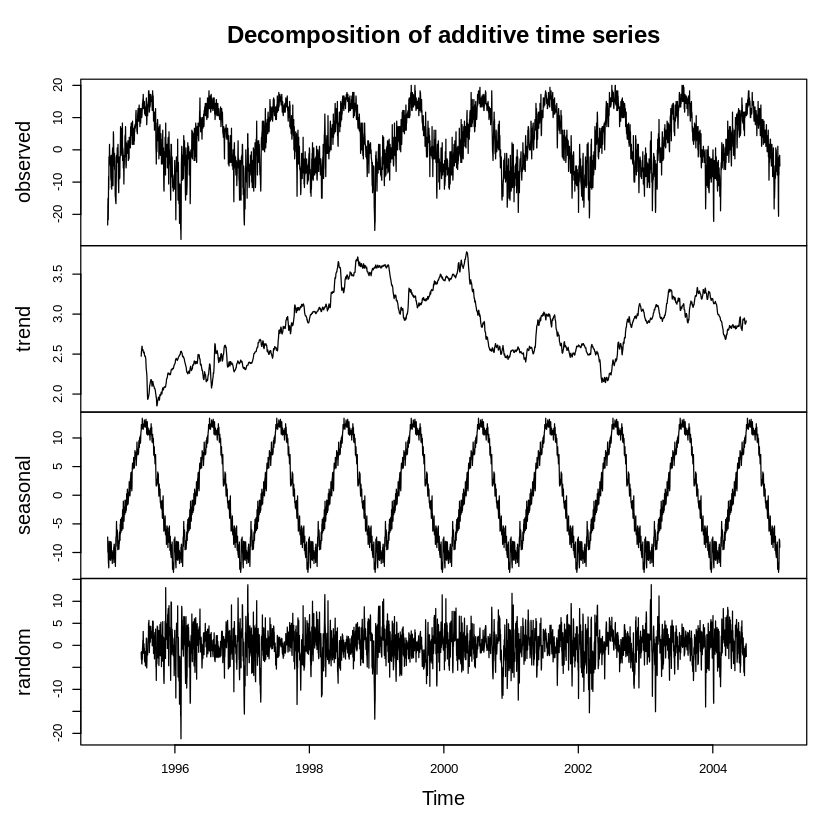

In [39]:
out <- decompose(dat.ts,type="additive") # additive is the default
names(out)
plot(out)

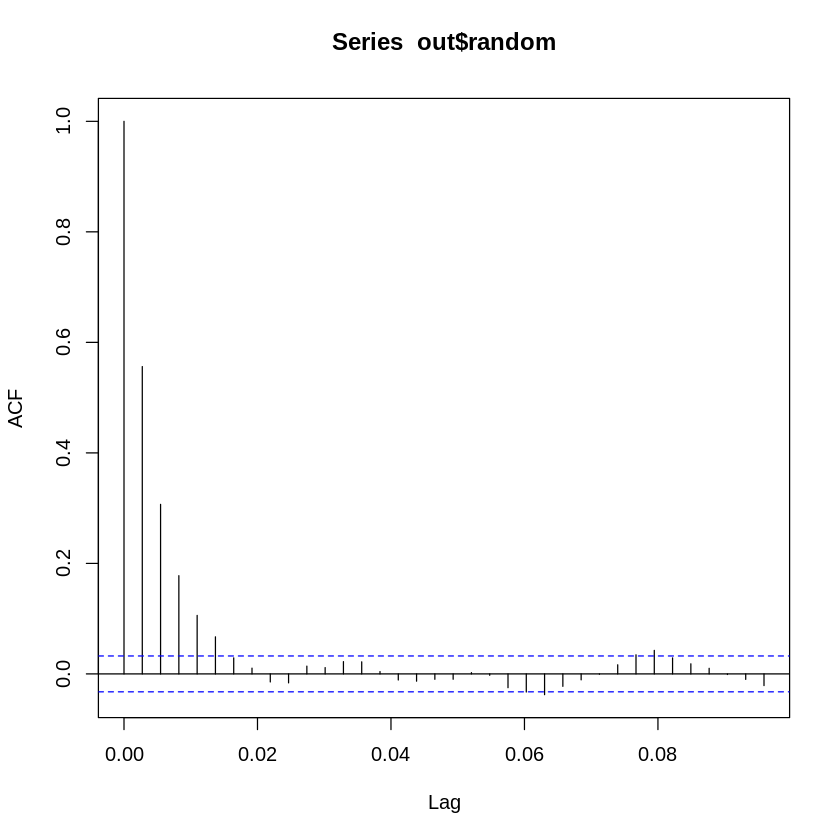

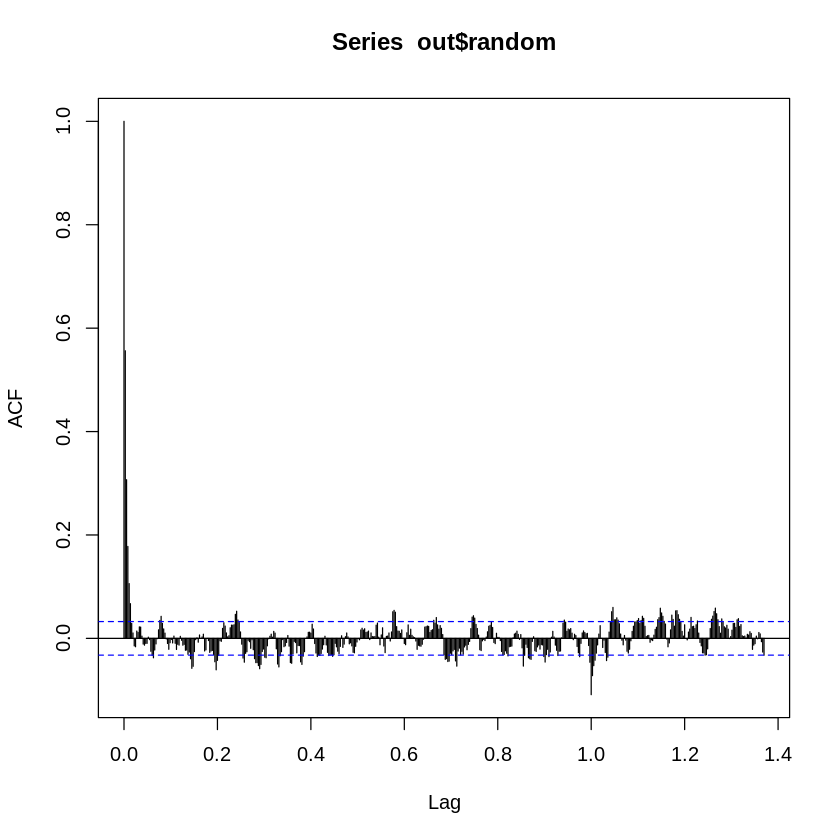

In [42]:
acf(out$random,na.action=na.pass)
acf(out$random,na.action=na.pass,lag.max=500)
abline(v=365,col="red")

Are these good results?
- The **trend** looks to have **overfit**
- The **seasonal** component is a bit noisy
- The **random** component still has a lot of correlation.  This isn't necessarily an indicator of something going wrong though.
  - This component is also shorter by one full period, due to the way the smoothing filter was applied (since it was a lag-365 filter). If you only have a few periods of observations, this may be a big deal

#### Another builtin: `stl`
[`stl`](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/stl), "stl: Seasonal Decomposition of Time Series by Loess"

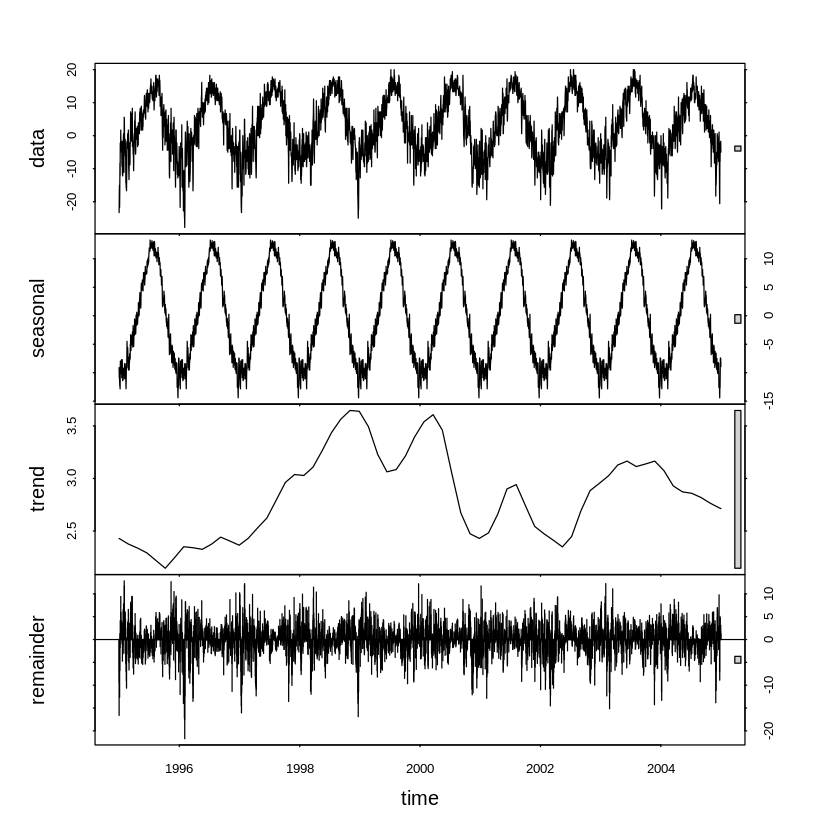

In [48]:
decomposed <- stl( dat.ts, s.window = 101 )
# decomposed <- stl( dat.ts, s.window = 7 ) # looks similar
# decomposed <- stl( dat.ts, s.window = "periodic" ) # looks similar
plot( decomposed )

## Trend/season removal: regression method

#### Model 0
Polynomial regression

Doing this with a quadratic isn't a bad idea

Doing this with degree 20 **is a bad idea**. So let's see it!

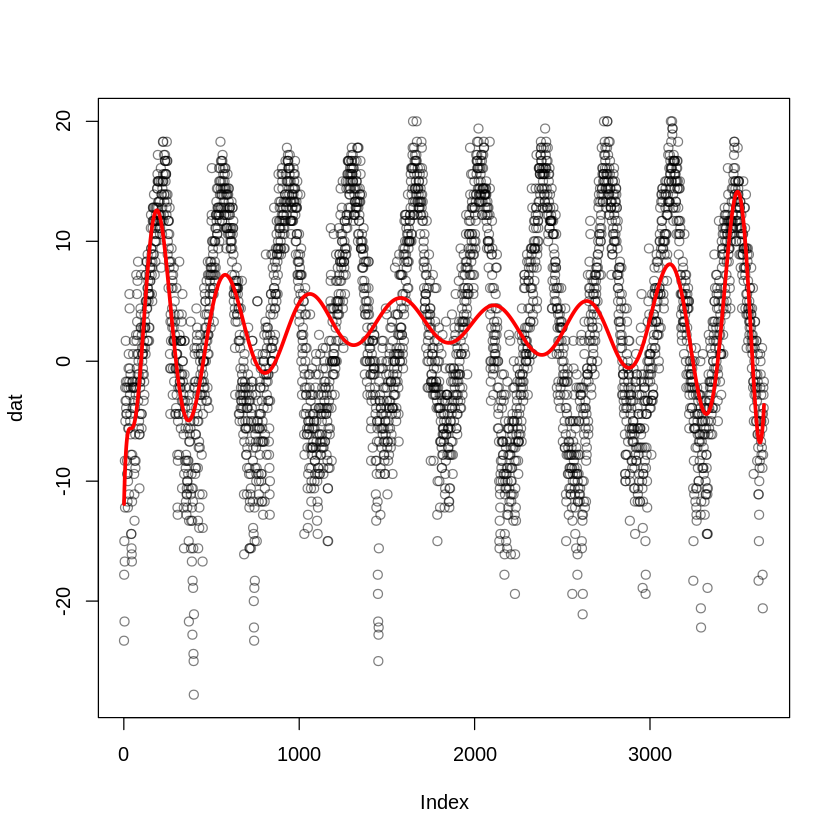

In [61]:
tm <- as.numeric( time(dat.ts))
fit <- lm(dat~poly(tm ,degree=20) )
# summary(fit)

plot(dat,type="p",col=gray(0, .5) )
lines(fit$fitted,col="red",lwd=3)

#### Model 1
$$\text{temp}(t) = \beta_0 + \beta_1 \cos(2\pi t/365) + \beta_2\sin(2\pi t/365) + \epsilon(t)
$$


Call:
lm(formula = dat ~ cos.c + sin.c)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.1006  -2.2252   0.2389   2.5333  13.4045 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.83186    0.06627   42.73   <2e-16 ***
cos.c       -10.56471    0.09373 -112.72   <2e-16 ***
sin.c        -3.12259    0.09373  -33.32   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.004 on 3647 degrees of freedom
Multiple R-squared:  0.7912,	Adjusted R-squared:  0.791 
F-statistic:  6908 on 2 and 3647 DF,  p-value: < 2.2e-16


(Intercept)       cos.c       sin.c 
   2.831863  -10.564714   -3.122594

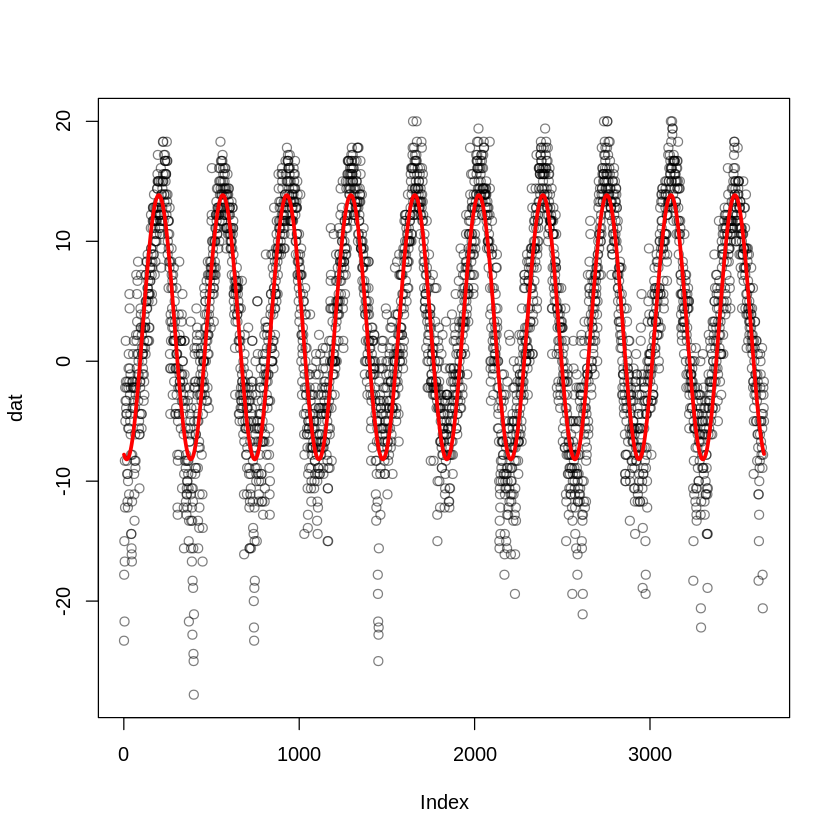

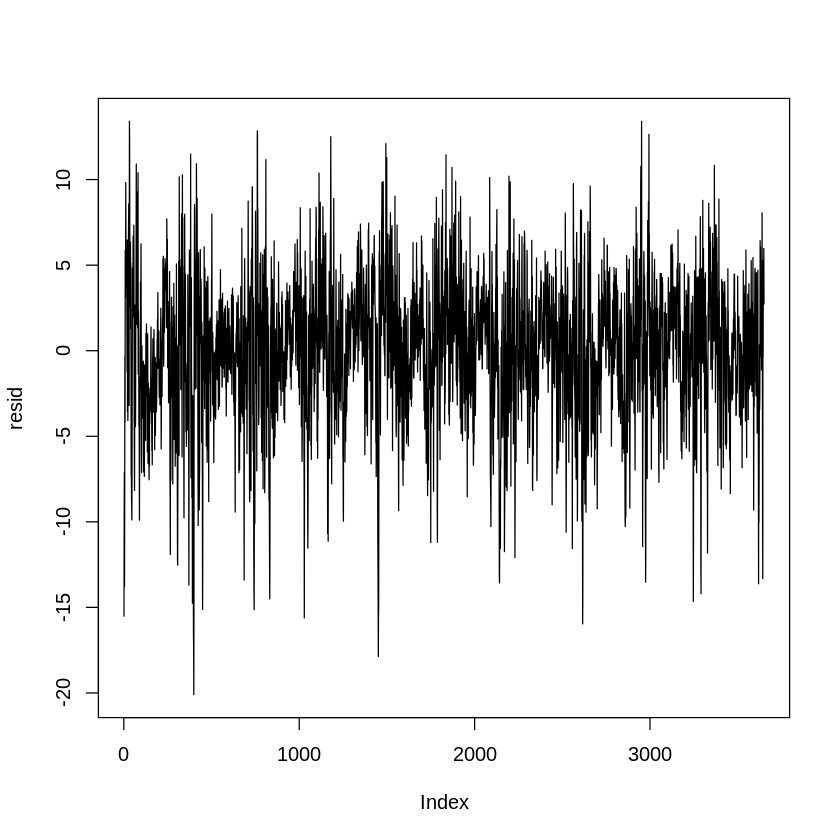

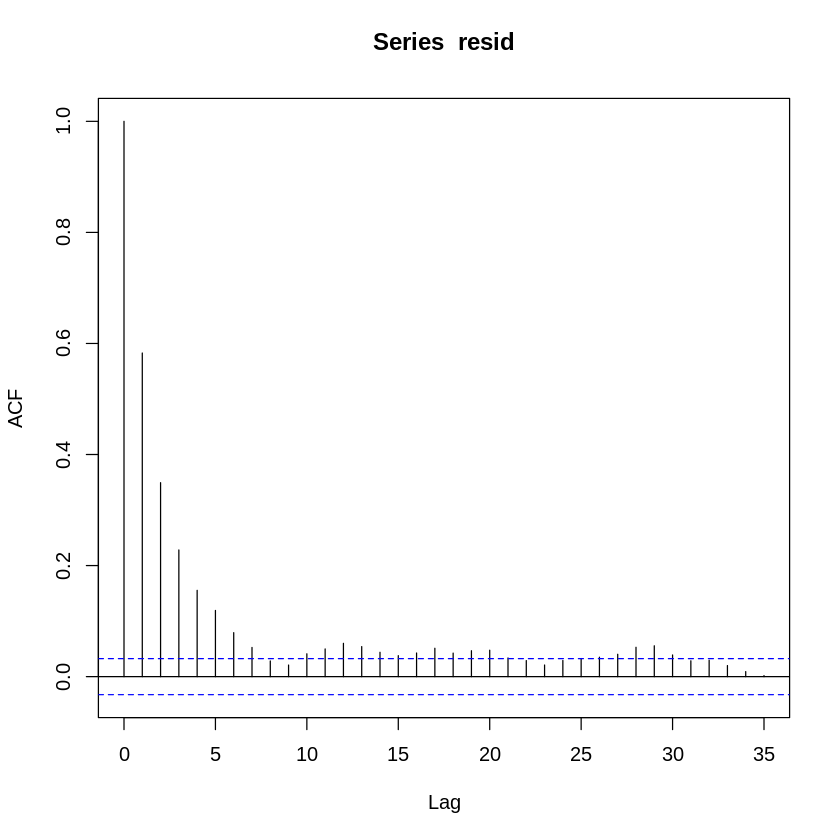

In [63]:
# set up seasonal harmonics
cos.c <- rep(cos(2*pi*1:365/365),10)
sin.c <- rep(sin(2*pi*1:365/365),10)

fit <- lm(dat~cos.c+sin.c)

summary(fit)
coef(fit)

plot(dat,type="p",col=gray(0, .5) )
lines(fit$fitted,col="red",lwd=3)

resid <- fit$resid
plot(resid,type="l")
acf(resid)

#### Model 2
Let $f_0 = 2\pi / 365$.
$$\text{temp}(t) = \beta_0 + \beta_1 \cos(f_0 t) + \beta_2\sin(f_0t) + \beta_3 \cos(2f_0t) + \beta_4\sin(2f_0 t) + \epsilon(t)
$$


Call:
lm(formula = dat ~ cos.c + sin.c + cos.c2 + sin.c2 + poly(tm, 
    degree = 2))

Residuals:
    Min      1Q  Median      3Q     Max 
-20.906  -2.141   0.142   2.395  12.902 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             2.83186    0.06470   43.768  < 2e-16 ***
cos.c                 -10.56222    0.09151 -115.425  < 2e-16 ***
sin.c                  -3.10709    0.09178  -33.853  < 2e-16 ***
cos.c2                  0.18583    0.09150    2.031  0.04234 *  
sin.c2                  1.18570    0.09157   12.948  < 2e-16 ***
poly(tm, degree = 2)1   8.48222    3.92394    2.162  0.03071 *  
poly(tm, degree = 2)2 -11.67609    3.90920   -2.987  0.00284 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.909 on 3643 degrees of freedom
Multiple R-squared:  0.8012,	Adjusted R-squared:  0.8008 
F-statistic:  2446 on 6 and 3643 DF,  p-value: < 2.2e-16


(Intercept)                 cos.c                 sin.c 
            2.8318630           -10.5622200            -3.1070902 
               cos.c2                sin.c2 poly(tm, degree = 2)1 
            0.1858302             1.1857011             8.4822218 
poly(tm, degree = 2)2 
          -11.6760907

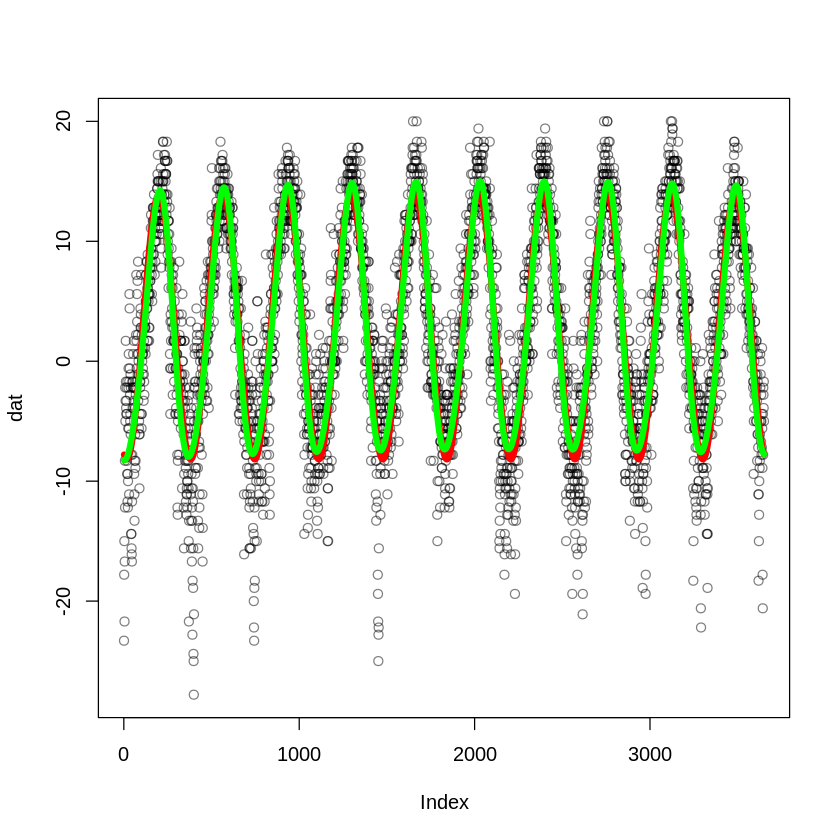

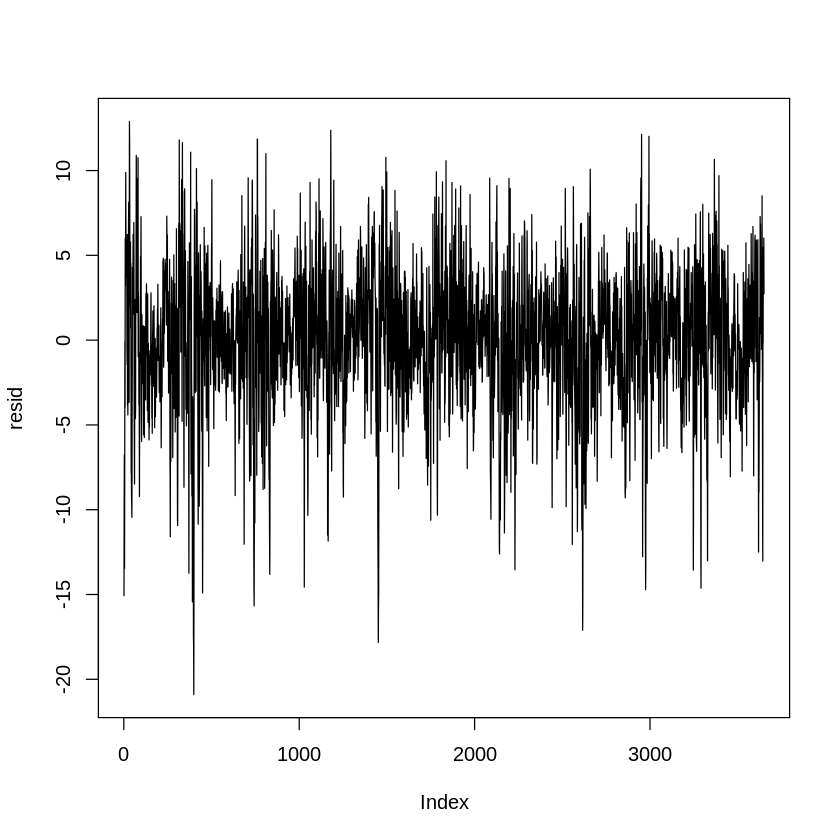

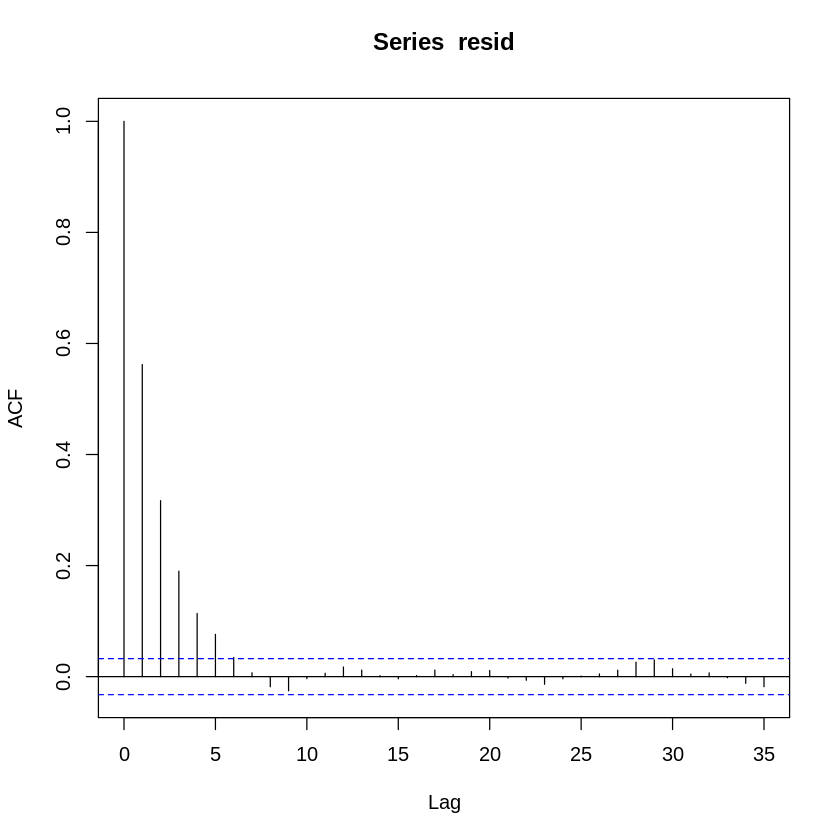

In [64]:
cos.c2 <- rep(cos(4*pi*1:365/365),10)
sin.c2 <- rep(sin(4*pi*1:365/365),10)

# fit2 <- lm(dat~cos.c+sin.c+cos.c2+sin.c2)

# or, include polynomial terms too
fit2 <- lm(dat~cos.c+sin.c+cos.c2+sin.c2 + poly(tm ,degree=2) )

summary(fit2)
coef(fit2)

plot(dat,type="p",col=gray(0, .5) )
lines(fit$fitted,col="red",lwd=5)
lines(fit2$fitted,col="green",lwd=5)

resid <- fit2$resid
plot(resid,type="l")
acf(resid)

# Try with another dataset
Daily female births in Californa in 1959

Do we expect to see annual, seasonal, or weekly trends?

[1] "d"

,Date,Daily.total.female.births.in.California..1959
,<chr>,<int>
1,1959-01-01,35
2,1959-01-02,32
3,1959-01-03,30
4,1959-01-04,31
5,1959-01-05,44
6,1959-01-06,29


,Date,Daily.total.female.births.in.California..1959
,<chr>,<int>
360,1959-12-26,34
361,1959-12-27,37
362,1959-12-28,52
363,1959-12-29,48
364,1959-12-30,55
365,1959-12-31,50


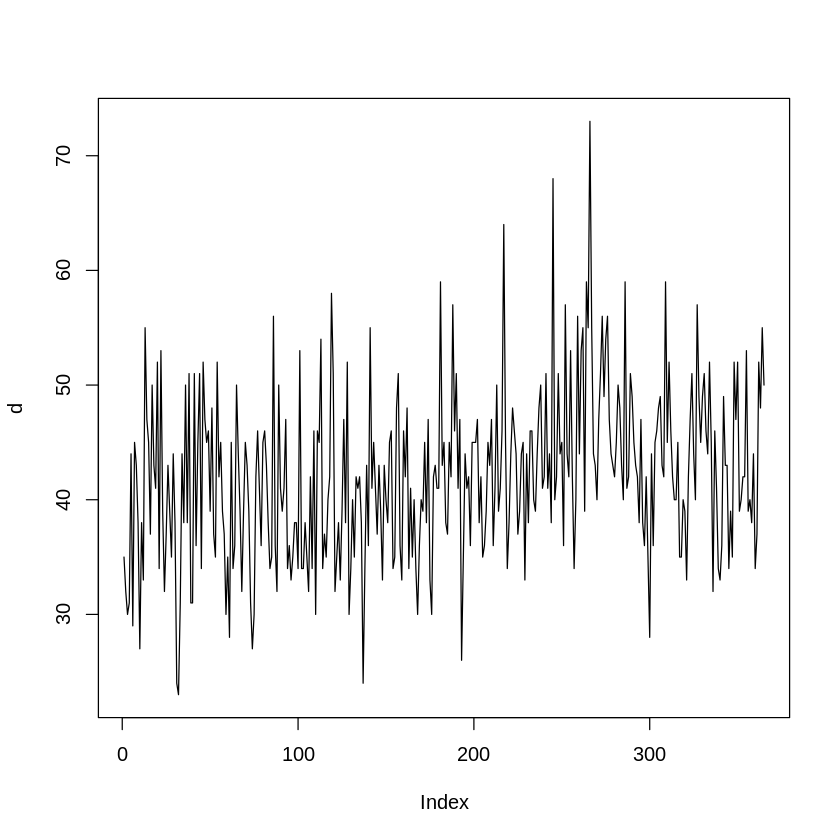

In [67]:
rm(list=ls()) # remove old variables from workspace

d <- read.csv("https://github.com/stephenbeckr/time-series-class/raw/main/Data/daily-total-female-births-in-cal.csv",sep=",",header=TRUE)

ls()

d <- d[-366,]

head(d)
tail(d)

#plot(d) # this doesn't work because we need to take the right column:
d <- d[,2]
plot(d,type="l")

Look at ACF.  A weekly pattern would show up at multiples of 7

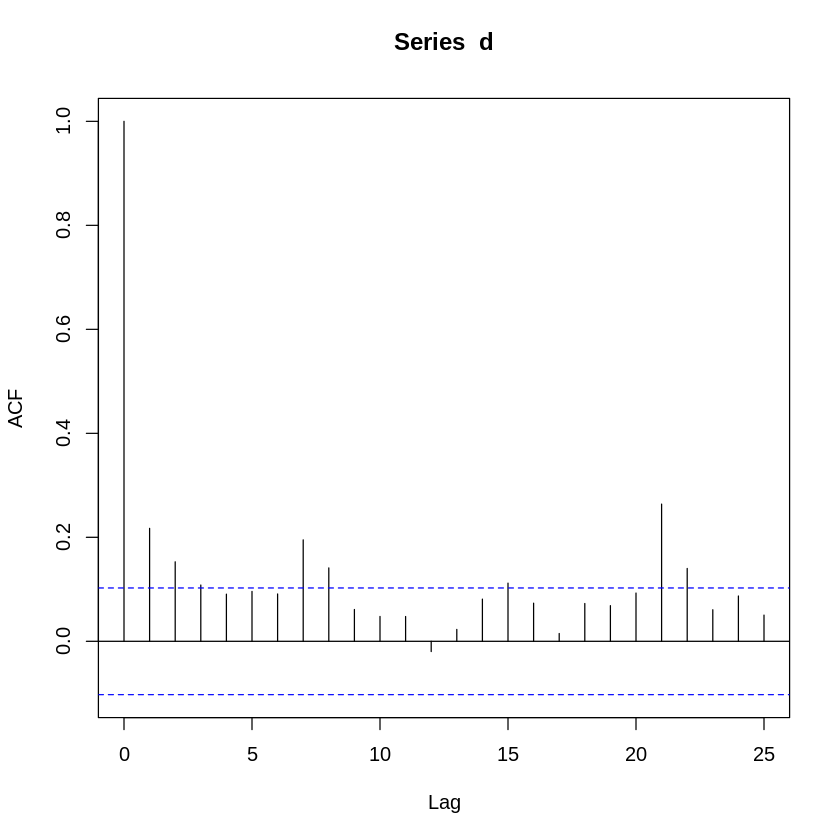

In [68]:
acf(d)

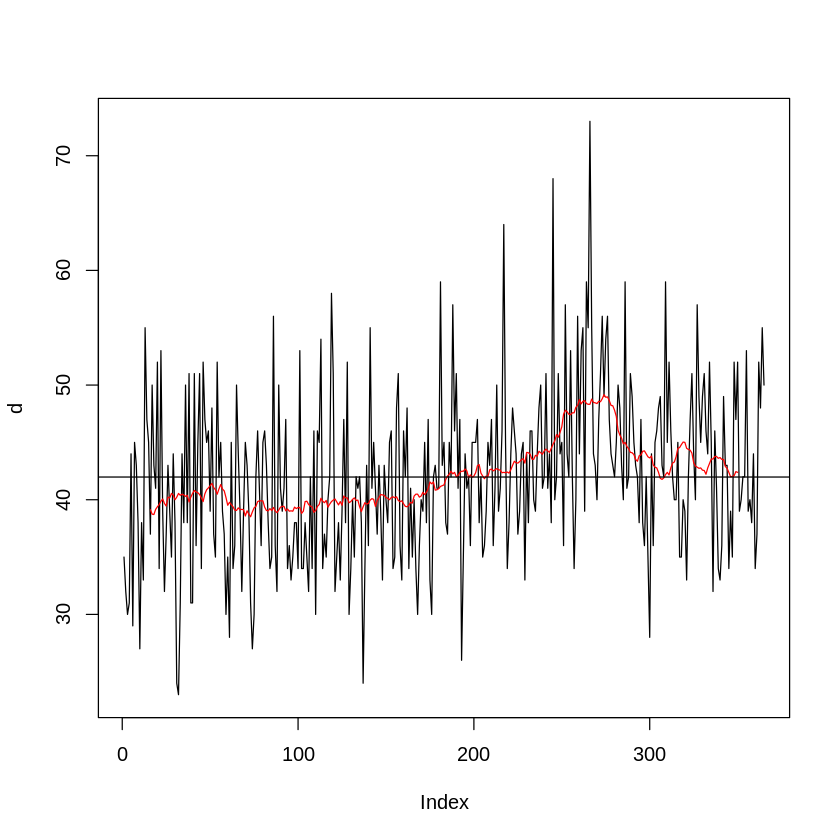

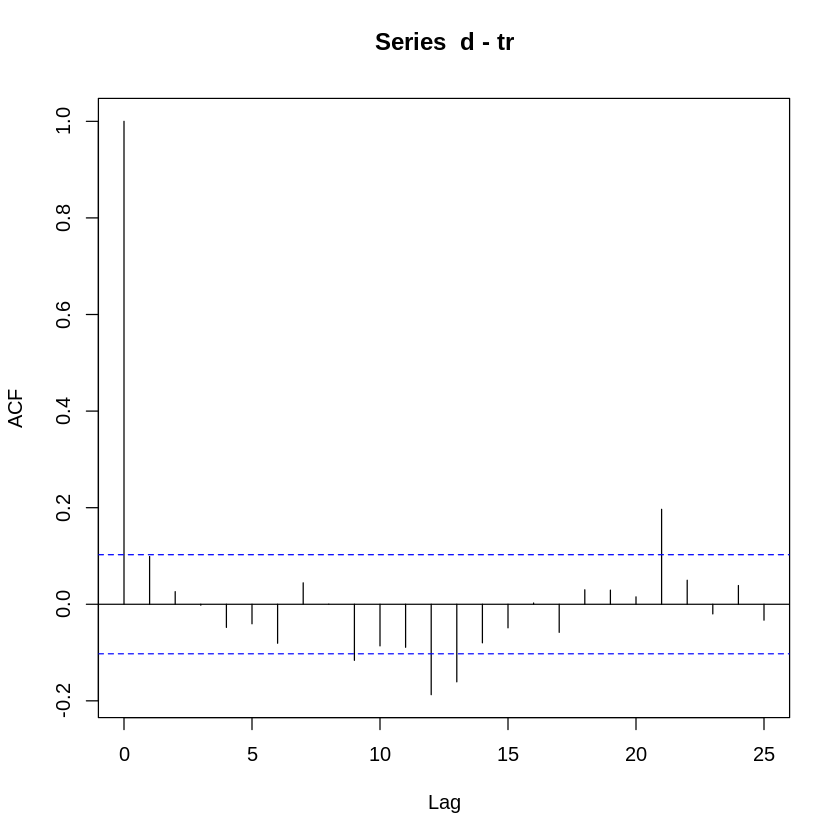

In [69]:
plot(d,type="l")
tr <- filter(x=d,filter=rep(1,31)/31,method="convolution",sides=2)
lines(tr,col="red")
abline(h=mean(d))

acf(d-tr,na.action=na.pass)

You could try the other types of trend removal we've discussed

# New dataset: sunspot numbers

[1] "d"

,Month,Zuerich.monthly.sunspot.numbers.1749.1983
,<chr>,<dbl>
1,1749-01,58.0
2,1749-02,62.6
3,1749-03,70.0
4,1749-04,55.7
5,1749-05,85.0
6,1749-06,83.5


,Month,Zuerich.monthly.sunspot.numbers.1749.1983
,<chr>,<dbl>
2815,1983-07,82.2
2816,1983-08,71.8
2817,1983-09,50.3
2818,1983-10,55.8
2819,1983-11,33.3
2820,1983-12,33.4


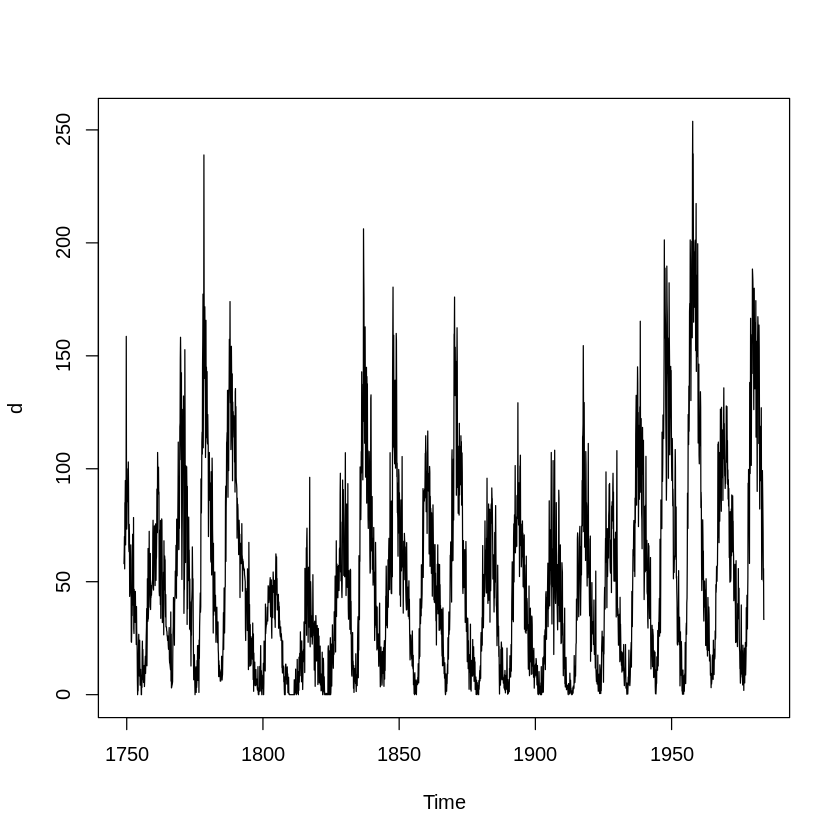

In [70]:
rm(list=ls()) # remove old variables from workspace

d <- read.csv("https://github.com/stephenbeckr/time-series-class/raw/main/Data/zuerich-monthly-sunspot-numbers-.csv",sep=",",header=TRUE)

ls()
d <- d[-2821,]

head(d)
tail(d)

d <- d[,2]
d <- ts(data=d,start=c(1749,1),end=c(1983,12),frequency=12)
plot(d)

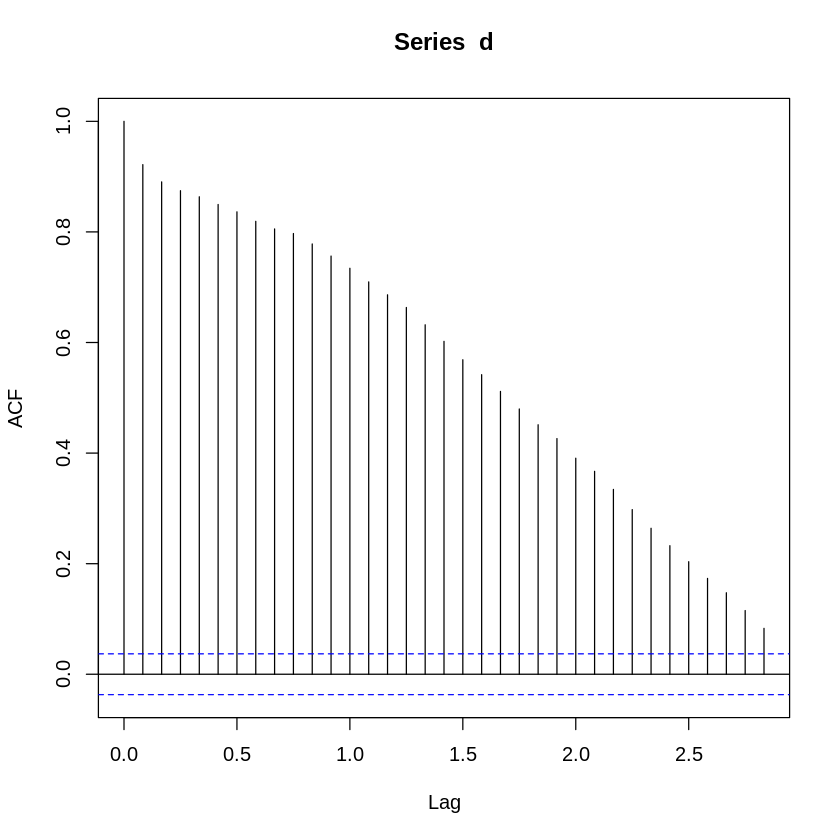

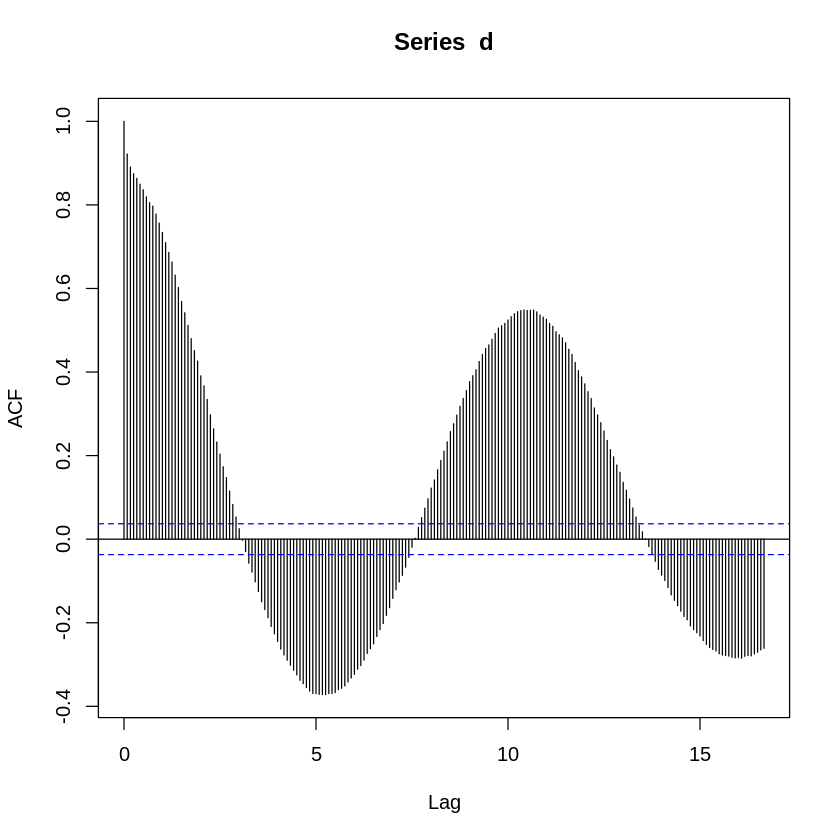

In [71]:
acf(d) # note how to interpret "Lag 1.0" (is that month? or year? What makes sense?)
acf(d,lag.max=200)

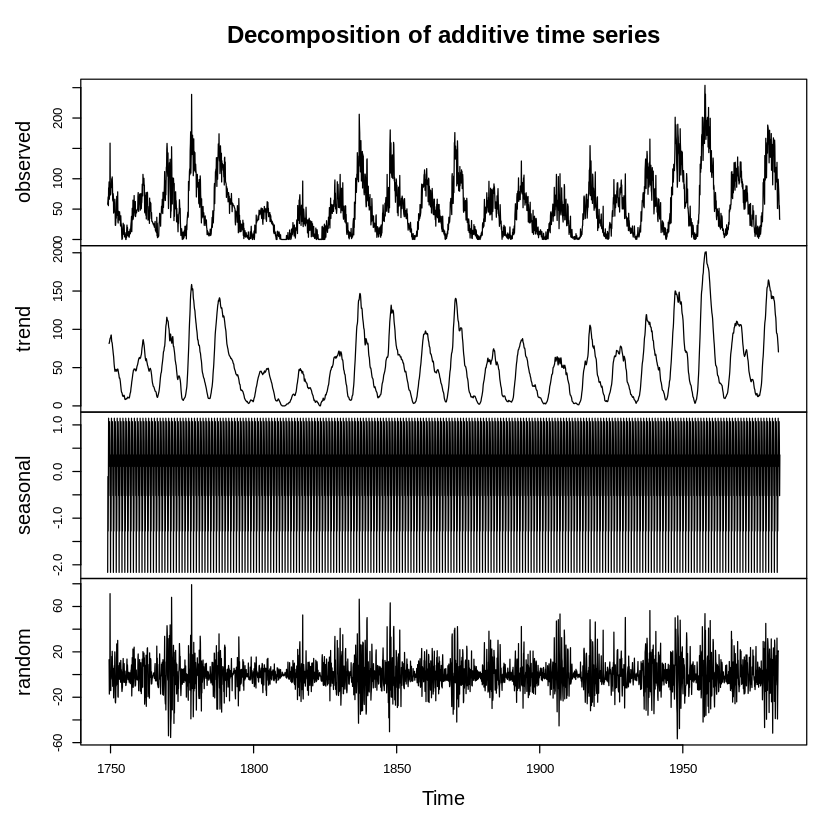

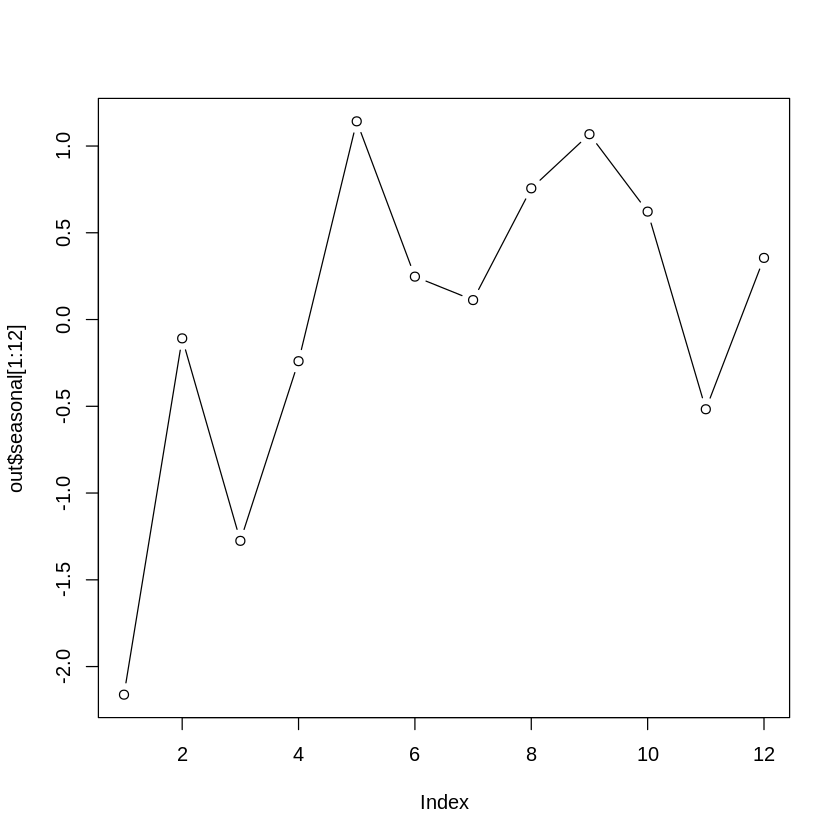

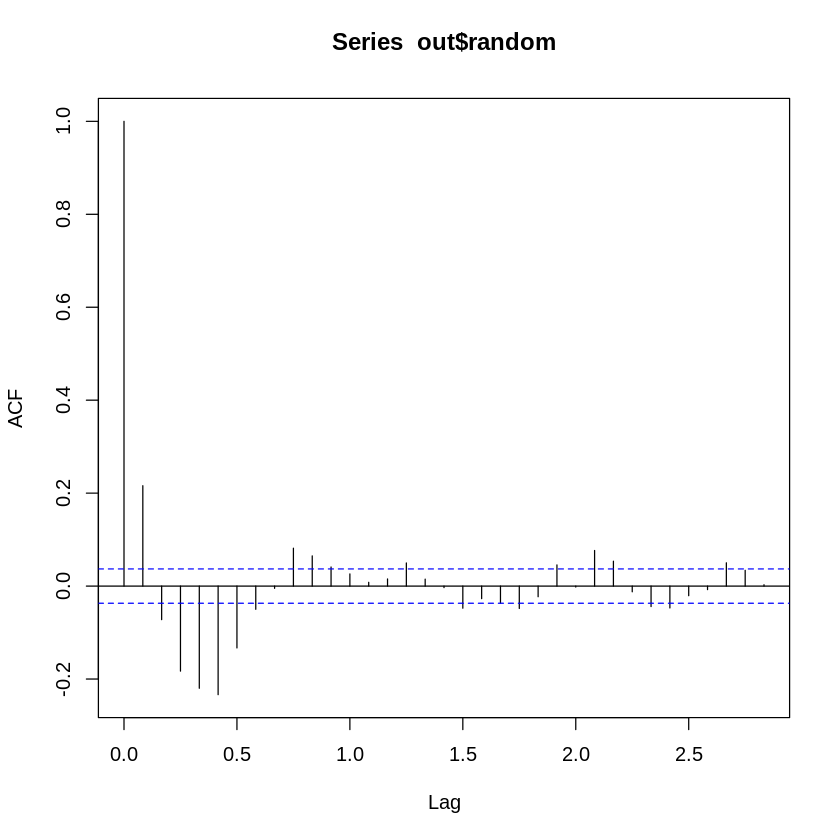

In [72]:
out <- decompose(x=d,type="additive")

plot(out)

plot(out$seasonal[1:12],type="b")

acf(out$random,na.action=na.pass)

That seasonal component doesn't look good!

We'll revisit these data when we get to **spectral methods**